In [65]:
import h5py
import os
import numpy as np
import pickle
import pandas as pd
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import pycbc.cosmology as cosmo
import pylab as plt

In [66]:
def decode_data(data):
    """
    Decodes byte strings or arrays of byte strings from HDF5.
    """
    if isinstance(data, bytes):
        return data.decode('utf-8')
    elif isinstance(data, np.ndarray) and data.dtype.kind in {'S', 'O'}:
        return [d.decode('utf-8') if isinstance(d, bytes) else d for d in data]
    else:
        return data

def load_from_h5_group(group, exclude_group_keys=None):
    """
    Recursively loads data from an HDF5 group and reconstructs Python objects.
    """
    result = {}

    # Check if this group is an array-style list (all keys are numeric)
    if exclude_group_keys == None:
        keys = list(group.keys())
    else:
        keys = [key for key in list(group.keys()) if key not in exclude_group_keys]
        
    if all(k.isdigit() for k in keys):
        # Treat it as a list, sorted by numeric key
        items = []
        for key in sorted(keys, key=lambda x: int(x)):
            val = group[key]
            if isinstance(val, h5py.Group):
                items.append(load_from_h5_group(val, exclude_group_keys=exclude_group_keys))
            else:
                items.append(decode_data(val[()]))
        return items

    # Otherwise treat as dict
    for key in group:
        if exclude_group_keys != None:
            if key in exclude_group_keys:
                continue
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_from_h5_group(item, exclude_group_keys=exclude_group_keys)
        else:
            result[key] = decode_data(item[()])

    return result

def load_results_from_h5(filename, exclude_group_keys=None):
    """
    Loads structured data from a universally saved HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        return load_from_h5_group(f, exclude_group_keys=exclude_group_keys)

## Load data

In [142]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
run_str = 'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_spins_in_FM_inj_set4'
n_events = 4342
posterior_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 
                              run_str + f'_z_posteriors_10K_corrected_prior_original_cov_{n_events}_events_pop_from_XPHM.pkl')
all_params_pos_file = os.path.join(project_dir, 'event_posterior_files', 'BBH', 'CE4020ET123', 
                                   run_str + f'_posteriors_10K_original_cov_{n_events}_events_pop_from_XPHM.h5')
fm_new_means_file = os.path.join(project_dir, 'GWBench_analysis', 'BBH', 
                             run_str + f'_{n_events}_events_pop_from_XPHM.h5')

In [143]:
with h5py.File(fm_new_means_file, 'r') as f:
    print(f.keys())
    #fm_new_means = [{key:val for key, val in f['new_mean_vals'][f'event_{i}'].items()} for i in range(len(f['new_mean_vals'].keys()))]
#fm_new_means = load_results_from_h5(fm_new_means_file)

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errs', 'inj_params']>


In [149]:
fm_inj_params = load_results_from_h5(fm_new_means_file, exclude_group_keys=['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errs'])

In [150]:
fm_inj_params.keys()

dict_keys(['inj_params'])

In [151]:
with h5py.File(all_params_pos_file, 'r') as f:
    print(f['event_0'].keys())
    include_keys = ['redshift', 'log_luminosity_distance', 'luminosity_distance']
    exclude_keys = [key for key in f['event_0'].keys() if key not in include_keys]

<KeysViewHDF5 ['chirp_mass', 'chirp_mass_source', 'inverted_mass_ratio', 'log_chirp_mass', 'log_luminosity_distance', 'luminosity_distance', 'mass_1', 'mass_1_source', 'mass_2', 'mass_2_source', 'mass_ratio', 'redshift', 'symmetric_mass_ratio']>


In [152]:
all_params_pos = load_results_from_h5(all_params_pos_file, exclude_group_keys=exclude_keys)

In [153]:
posterior_dict_list = pd.read_pickle(posterior_file)

In [156]:
posterior_samples_list = [posterior_dict_list[i]['redshift'] for i in range(len(posterior_dict_list))]
prior_samples_list = [posterior_dict_list[i]['prior'] for i in range(len(posterior_dict_list))]
true_redshifts = [fm_inj_params['inj_params'][i]['z'] for i in range(len(fm_inj_params['inj_params']))]

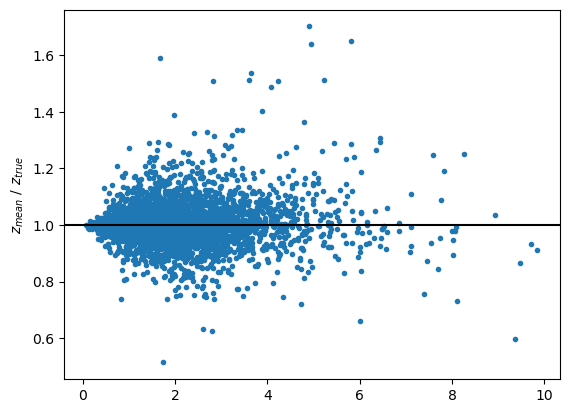

In [157]:
plt.plot(true_redshifts, [np.mean(posterior_samples_list[i])/true_redshifts[i] for i in range(len(posterior_samples_list))], '.')
plt.ylabel('$z_{mean}\ /\ z_{true}$')
plt.axhline(1, c='k')

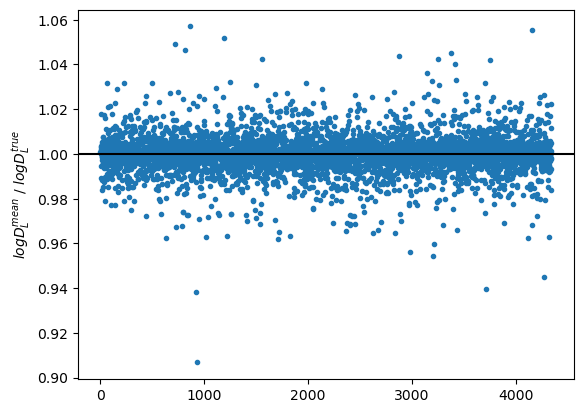

In [159]:
plt.plot([np.mean(all_params_pos[f'event_{i}']['log_luminosity_distance'])/np.log(fm_inj_params['inj_params'][i]['DL']) for i in range(len(all_params_pos))], 
         '.')
plt.ylabel('$log D_L^{mean}\ /\ log D_L^{true}$')
plt.axhline(1, c='k')

## Calculate P-P values

In [160]:
from scipy.stats import percentileofscore

def compute_posterior_cdf(posterior_samples, true_z):
    return percentileofscore(posterior_samples, true_z, kind='rank') / 100.0

In [161]:
pp_values = []

for posterior_samples, prior_samples, true_z in zip(posterior_samples_list, prior_samples_list, true_redshifts):
    cdf_val = compute_posterior_cdf(posterior_samples, true_z)
    pp_values.append(cdf_val)

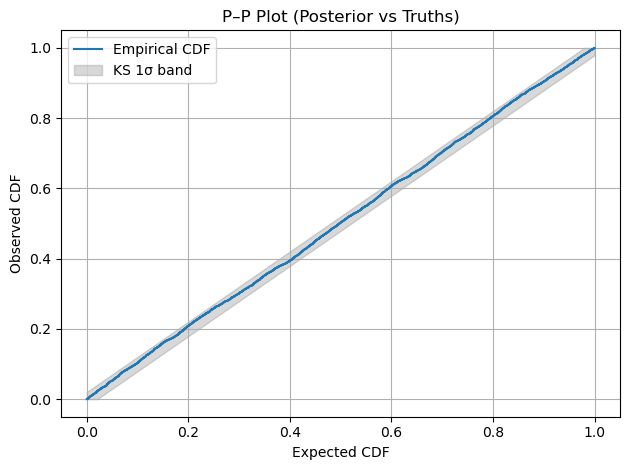

In [164]:
import numpy as np
import matplotlib.pyplot as plt

pp_values = np.array(pp_values)
pp_values.sort()

n = len(pp_values)
expected = np.linspace(0, 1, n)

plt.plot(expected, pp_values, drawstyle='steps-post', label='Empirical CDF')
#plt.plot(expected, expected, 'k--', label='Expected (1:1 line)')
plt.fill_between(expected,
                 np.maximum(0, expected - 1.36/np.sqrt(n)),
                 np.minimum(1, expected + 1.36/np.sqrt(n)),
                 color='gray', alpha=0.3, label='KS 1σ band')

plt.xlabel('Expected CDF')
plt.ylabel('Observed CDF')
plt.title('P–P Plot (Posterior vs Truths)')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [163]:
from scipy.stats import kstest

statistic, pvalue = kstest(pp_values, 'uniform')
print(f"KS p-value: {pvalue:.5f}")

KS p-value: 0.69531
